# Mini Project 3 - Group 12

In [1]:
#Importing Necessary Libraries
import os
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from collections import Counter
from wordcloud import WordCloud
import re
from pprint import pprint
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy # spaCy for preprocessing
import pyLDAvis # Plotting tools
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Loading the dataset
def load_data(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                content = file.read()
                data.append(content)
    return data

directory = 'Articles' # Replace with the path to your text files
raw_data = load_data(directory)


In [3]:
#cleaning the initail raw_data
for i in range(len(raw_data)):
    raw_data[i]=raw_data[i].replace("''","")
    raw_data[i]=raw_data[i].replace("\"","")
    raw_data[i]=raw_data[i].replace("* ","")

In [4]:
# seperating articles and meta data
corp=[]
for i in [x.split(sep="\n\n") for x in raw_data]:
    for j in i:
        corp.append(j)

# 1. Preprocessing and exploratory data analysis

In [5]:
#creating the meta list from observation
meta_list=[r"^[\(]\w+[\)]$", #start and end with ()
           r"^[\d].+[\d]$", #starts and end with number
           r"^[_,].+[_,]$", #starts and ends with _ or ,
           "All Rights Reserved", #meta data
           r"words\n", #meta data of word count
           r"Document ", #mets data of document
           r"Norton & Company.",
           r"Illustrated. ",
           r"Book Review",
           r"(Follow|Sign|Get)*(newsletter)", #meta data of promotions
           r"^(By|Y) (Noah|Glenn|Pankaj|Ali|Graeme|Elliot|Tim|Mathias|Kamila|Jorie|Ryan|Sam|Daisy|Dave|Gregor|Matt|Gilles)"
          ]

In [6]:
#printing the changes in corpus after removing each meta sample
print(len(corp))
for met in meta_list:
    for txt in corp:
        if re.search(met, txt):
            corp.remove(txt)
    print(len(corp),"->",met)

53526
53382 -> ^[\(]\w+[\)]$
53225 -> ^[\d].+[\d]$
52702 -> ^[_,].+[_,]$
51082 -> All Rights Reserved
51061 -> words\n
49415 -> Document 
49410 -> Norton & Company.
49405 -> Illustrated. 
49362 -> Book Review
49005 -> (Follow|Sign|Get)*(newsletter)
48981 -> ^(By|Y) (Noah|Glenn|Pankaj|Ali|Graeme|Elliot|Tim|Mathias|Kamila|Jorie|Ryan|Sam|Daisy|Dave|Gregor|Matt|Gilles)


In [7]:
for i in range(len(corp)):
    corp[i] = re.sub(r"^[\n](National|EDITORIAL|Editorial).+(opinion|Desk).+[\n]", '', corp[i],flags=re.IGNORECASE)
    corp[i] = re.sub(r"[\(].+[PHOTO*|DRAW*|POOL*].+BY.+[\)]", '', corp[i],flags=re.IGNORECASE)
    corp[i] = re.sub(r"[\\]b\d?", '', corp[i],flags=re.IGNORECASE)
    corp[i] = re.sub(r"[\n]world[\n]", '', corp[i],flags=re.IGNORECASE)
    corp[i] = re.sub(r"[\(].+[\)]", '', corp[i],flags=re.IGNORECASE)
    corp[i] = re.sub(r"[\[].+[\]]", '', corp[i],flags=re.IGNORECASE)
    corp[i] = re.sub(r"[\n](U.S.|us|FIRST|Magazine|Desk|World|SECT*|Opinion|Review|Style|Briefing|COLUMNIST|Television|Daily|ART|technology|Conversation|Edit*|NOTEBOOK|JOURNAL|ANALYS*|NEWS|NYT|FEATURE*|WRITER|Week|Last|Movie*|Region|Today|Web)[\n]",
                     '', corp[i],flags=re.IGNORECASE)

### Looking into length distribution of articles after removing possible metadata

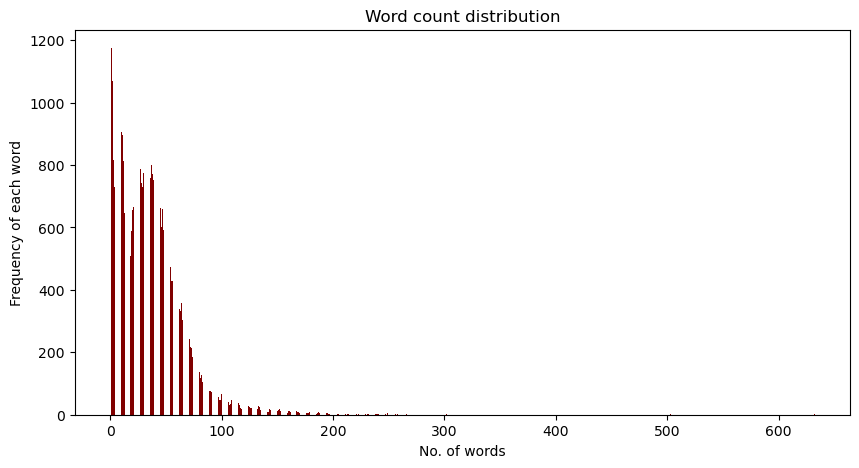

In [8]:
len_distribution=pd.DataFrame([len(i.split()) for i in corp])
ldd={i:len(len_distribution[len_distribution[0]==i]) for i in len_distribution[0].unique()}
import matplotlib.pyplot as plt


count = list(ldd.keys())
frequency = list(ldd.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(count, frequency, color ='maroon',
        width = 0.4)
 
plt.xlabel("No. of words")
plt.ylabel("Frequency of each word")
plt.title("Word count distribution")
plt.show()

#### We Observed that we got a lot of observations with very few words which probably bare very little information

In [9]:
for i in range(10):
    print("word count",i,"->",ldd[i])

word count 0 -> 305
word count 1 -> 1175
word count 2 -> 1068
word count 3 -> 815
word count 4 -> 731
word count 5 -> 657
word count 6 -> 805
word count 7 -> 725
word count 8 -> 1045
word count 9 -> 850


In [10]:
import numpy as np
for i in range(5):
    temp=np.array([x for x in corp if len(x.split())==i])
    print(i,"words ->",len(temp),"->",pd.DataFrame(temp)[0].unique())
    

0 words -> 305 -> [' ' '' '\xa0']
1 words -> 1175 -> ['DRAWING  ' '.' 'MERTO/WILLEY ' 'DRAWING ' 'Business' 'Noteworthy'
 'QUESTION: ' 'Yes?' 'No...' 'OK.' 'END' 'TRUMP: ' '“henomenal”' '  Weeks'
 'Weather' 'Patience.' '—TD.' 'Trump  ' 'Saturday' 'Sunday'
 'Close-reading' 'Summarizing' 'Annotating' 'DRAWINGS  ' 'NATO'
 "obsolete.'" 'exporters.' 'Syria' 'Students' 'More?' 'Sincerely,'
 'Philadelphia' 'Respectfully,' 'Sincerly,' 'O.K.?' 'Fourth:' 'Naturally.'
 'Yeah?' 'OK?' 'Coverage' '----' 'QUEBEC' 'OTTAWA' 'PARIS' 'BOSTON'
 'CAIRO' 'COPENHAGEN' 'LONDON' 'PHILADELPHIA' 'ISTANBUL' 'BRUSSELS'
 'SYDNEY' 'MANILA' 'BERLIN' 'Secularism' 'Detergent.' 'Yemen' 'Iraq'
 'Sudan' 'Somalia' 'Shannon' 'Activity' 'COMPASS' 'Defenseless' 'PHOTO '
 '$27.95.' 'FAST' 'Winner' 'Runners-Up' 'Godspeed.' '--' 'Hadba.' 'Artist'
 'Composer' 'Swimming.' '---' 'Related' 'Correction' '***' 'Joe?' 'John?'
 '#MeToo.' 'Italy' 'Europe' 'CANADA' 'RUSSIA' 'GERMANY' 'AFGHANISTAN'
 'Colin?' 'Kim?' 'AUSTRALIA' 'INDIA' 'IND

2 words -> 1068 -> ['Correction Appended' 'Corrections Appended' 'EXECUTIVE ORDER'
 'HIGH NOON' 'Other Gossip' 'Good morning.' 'Smarter Living' 'Back Story'
 'Background reading:' '\nThe Conversation#OscarsSoOrange'
 'Chas. Schwartz' 'Hank Green' 'Tim Lahan ' 'QUESTION: .' 'TRUMP: Yeah.'
 'QUESTION: ?' 'TRUMP: OK.' 'Go ahead.' 'QUESTION: BBC.'
 'QUESTION: Mr....' 'QUESTION: ...' 'Because ...' 'TRUMP: Right.'
 'TRUMP: Yes.' 'TRUMP: Yep.' 'Dangerous Alliance' 'HABERMAN: Really.'
 'TRUMP: Huh?' 'HABERMAN: Really?' 'THRUSH: President?' 'HABERMAN: Yeah.'
 'THRUSH: Yeah.' 'HABERMAN: Explain.' 'HABERMAN: O.K.' 'TRUMP: No.'
 'TRUMP: Me.' 'Chemical Weapons' 'Scud Missiles' 'Chemical weapons'
 'Scud missiles' '•rom TruthDig:' '•rom Salon:' '•rom Politico:'
 '•rom BuzzFeed:' '•rom Washingtonian:' 'Will Conway' 'Tom Hammerschmidt'
 'Doug Stamper' 'Thomas Yates' 'Catherine Durant' 'Welcome back.'
 'And Finally...' 'RE: HOMEOWNERSHIP' '--Steven Erlanger' '--James Kanter'
 '--Alison Smale' '--Claire 

3 words -> 815 -> [' of this section.' 'DONALD J. TRUMP' 'THE WHITE HOUSE,' 'March 6, 2017.'
 'What about terrorism?' 'Recent threats ...' 'The letter reads:'
 'which translates to:' '• geopolitical whodunit.' '•merica’ aging dams.'
 'On today’ episode:' 'On Google Home:' 'The Meatloaf Diet' 'AGE OF ANGER'
 'Lynn Caporale, Manhattan' 'Yes, go ahead.' 'OK, go ahead.'
 'TRUMP: We are.' 'QUESTION:  clarify --' 'QUESTION: -- inauguration.'
 'TRUMP: Excuse me.' 'QUESTION: Yes, sir.' 'TRUMP: Go ahead.'
 'TRUMP: Not good.' 'QUESTION: Can we...' 'TRUMP: Yeah. Sure.'
 'QUESTION: Mr. President...' 'Sanctions and Isolation' '7. It’ official.'
 'TRUMP: I do.' 'HABERMAN: How come?' 'HABERMAN: No? O.K.'
 'HABERMAN: You are.' 'TRUMP: I am.' 'TRUMP: Very simple.'
 "HABERMAN: That's right." 'Targeting of Hospitals'
 'HABERMAN: That’ right.' 'TRUMP: —n Davis-Bacon.'
 'The Punchiest Punchlines' 'Almost as phenomenal:' '•“t went crazy.”'
 'In the News' 'From the Right' '•rom National Review:' '•rom Red St

#### From the above analysis we can say that samples of less than 4 words contains no less meaningfull information, So we are removing those samples too

In [11]:
corp=[x for x in corp if len(x.split())>=4]

In [12]:
corp #articles after cleaning and preprocessing

['Trump Adopting Hands-Off Style Toward Military',
 'WASHINGTON -- President Trump is shifting more authority over military operations to the Pentagon, according to White House officials, reversing what his aides and some generals say was a tendency by the Obama White House to micromanage issues better left to military commanders.',
 "The change is at the heart of a re-engineering of the National Security Council's role under its new leader, Lt. Gen. H. R. McMaster, and reflects Mr. Trump's belief that the N.S.C. should focus less on military operations and tactics and more on strategic issues. A guiding precept for the president and his team is that the balance of power in the world has shifted against American interests, and that General McMaster should focus on developing foreign and economic policy options in concert with the Pentagon, State Department and other agencies to respond to that challenge.",
 'The new approach to managing military operations was evident this month when a

# Preprocessing of data

**Corpus Building**

In [13]:
#Pre-processing the data
def preprocess_data(raw_data):
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    
    lemmatizer = WordNetLemmatizer()
    stop_words = nltk.corpus.stopwords.words('english')
    new_stopwords = ["say","said","time"]
    stop_words.extend(new_stopwords)

    preprocessed_data = []
    for document in raw_data:
        tokenized_words = word_tokenize(document.lower())
        cleaned_words = [word for word in tokenized_words if word.isalnum() and word not in stop_words]
        lemmatized_words = [lemmatizer.lemmatize(word) for word in cleaned_words]
        preprocessed_data.append(lemmatized_words)
    return preprocessed_data

preprocessed_data = preprocess_data(corp)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saijagadeeshyadavalli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saijagadeeshyadavalli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saijagadeeshyadavalli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/saijagadeeshyadavalli/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [14]:
preprocessed_data = ' '.join([' '.join(doc) for doc in preprocessed_data])

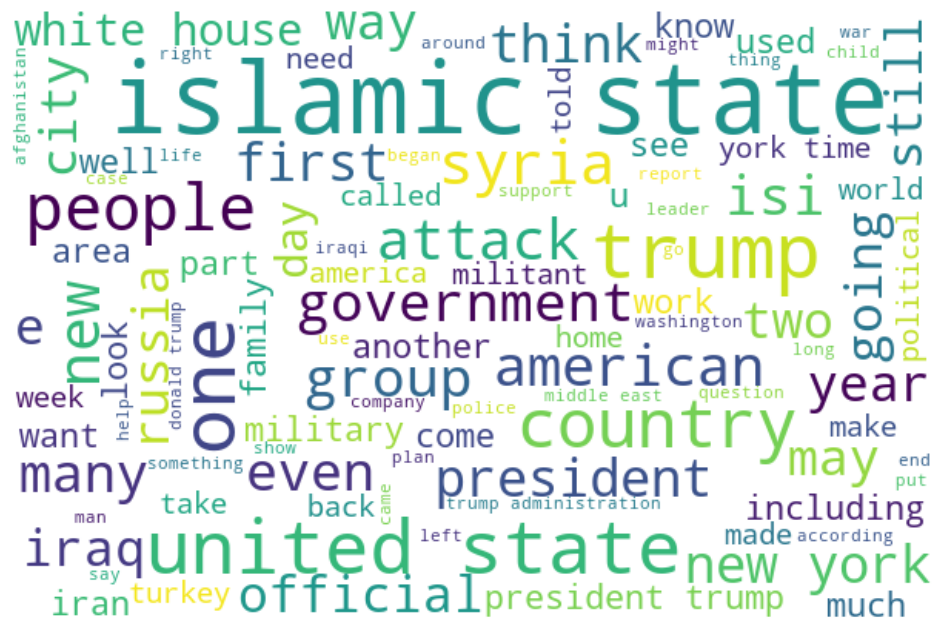

In [15]:
# Word Cloud Representation of Most commonly used Words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text, max_words=100):
    wordcloud = WordCloud(width=600, height=400, background_color='white', max_words=max_words).generate(text)

    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

generate_word_cloud(preprocessed_data)


**Data Pre-processing**

In [16]:
import re

def extract_metadata(text):
    metadata = {}
    # Extract metadata here (e.g., title, author, date, etc.)
    # Example: metadata['title'] = re.search('TITLE_PATTERN', text).group(1)
    
    # Remove metadata from the text
    cleaned_text = re.sub('METADATA_PATTERN', '', text)
    return metadata, cleaned_text

def preprocess_data(raw_data):
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    preprocessed_data = []
    metadata_list = []

    for document in raw_data:
        metadata, cleaned_text = extract_metadata(document)
        metadata_list.append(metadata)

        tokenized_words = word_tokenize(cleaned_text.lower())
        cleaned_words = [re.sub(r'[^\w\s]', '', word) for word in tokenized_words if word.isalnum() and word not in stop_words]
        lemmatized_words = [lemmatizer.lemmatize(word) for word in cleaned_words]
        preprocessed_data.append(lemmatized_words)
    
    return metadata_list, preprocessed_data

metadata_list, preprocessed_data = preprocess_data(raw_data)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saijagadeeshyadavalli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saijagadeeshyadavalli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saijagadeeshyadavalli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
dictionary = Dictionary(preprocessed_data)
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_data]

**Feature Extraction**

In [18]:
def print_features(corpus, dictionary, document_index=0, num_features=10):
    bow_doc = corpus[document_index]
    sorted_bow = sorted(bow_doc, key=lambda x: x[1], reverse=True)

    print(f"Top {num_features} words in document {document_index}:\nWord\tFrequency")
    for word_id, freq in sorted_bow[:num_features]:
        print(f"{dictionary[word_id]}\t{freq}")

print_features(corpus, dictionary, document_index=0, num_features=10)

Top 10 words in document 0:
Word	Frequency
state	895
trump	837
said	644
new	504
united	492
time	467
country	394
american	365
people	359
president	320


In [19]:
for i in range(1, 18):
    print_features(corpus, dictionary, document_index=i, num_features=10)

Top 10 words in document 1:
Word	Frequency
trump	840
said	762
state	739
syria	590
time	471
new	448
president	400
american	399
islamic	352
military	338
Top 10 words in document 2:
Word	Frequency
said	783
trump	577
state	545
time	426
new	407
attack	389
islamic	363
president	338
manchester	308
people	304
Top 10 words in document 3:
Word	Frequency
said	741
state	622
time	511
new	479
trump	434
facebook	358
american	349
islamic	319
york	319
president	294
Top 10 words in document 4:
Word	Frequency
said	798
trump	754
state	712
new	514
time	474
one	381
would	353
united	351
people	343
president	343
Top 10 words in document 5:
Word	Frequency
state	972
trump	845
said	815
new	545
united	514
islamic	476
time	445
american	403
president	399
order	374
Top 10 words in document 6:
Word	Frequency
state	114
obama	94
said	89
afghanistan	86
attack	60
american	57
islamic	56
new	55
war	54
president	52
Top 10 words in document 7:
Word	Frequency
state	970
said	870
islamic	671
time	432
new	370
group	350
force	340

In [20]:
from collections import defaultdict
import numpy as np

def print_summary(corpus, dictionary, num_features=10):
    word_freqs = defaultdict(int)
    doc_lengths = []

    for doc in corpus:
        doc_length = 0
        for word_id, freq in doc:
            word_freqs[word_id] += freq
            doc_length += freq
        doc_lengths.append(doc_length)

    sorted_word_freqs = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)

    print(f"Top {num_features} words across all documents:\nWord\tFrequency")
    for word_id, freq in sorted_word_freqs[:num_features]:
        print(f"{dictionary[word_id]}\t{freq}")

    print(f"\nAverage word frequency: {np.mean(list(word_freqs.values())):.2f}")
    print(f"Average document length: {np.mean(doc_lengths):.2f}")

print_summary(corpus, dictionary, num_features=10)


Top 10 words across all documents:
Word	Frequency
said	11693
state	10457
trump	7730
islamic	6289
new	6230
time	5932
president	4372
one	4283
american	4088
syria	4082

Average word frequency: 28.10
Average document length: 58948.06


**Summarizing the features**

The results illustrates that there is a significant focus on politics and current events, as evidenced by the high frequency of words such as "state," "Trump," "president," and "Syria." The prominence of words like "Islamic" and "Iraq" suggests a focus on Middle Eastern politics and possibly terrorism. 

1) America has been involved in Syria since 2014, when it started leading an international coalition to fight against ISIS.

2) Turkey has been involved in Syria since 2011, when the Syrian civil war began. It has launched military operations in Syria against Kurdish militias that it considers to be terrorists.

3) America and Turkey have had a complicated relationship in Syria. Turkey has criticized America's support for Kurdish militias, which Turkey sees as a threat to its national security.

4) In 2017, Trump ordered a missile strike on a Syrian airbase.

5) In 2018, Trump announced that he was withdrawing American troops from Syria, saying that the mission to defeat ISIS had been accomplished.

6)  The Islamic State (ISIS) is a threat to every country, ISIS is a major terrorist group that has seized control of large swaths of territory in Syria and Iraq. The US and Turkey are both working to defeat ISIS

7) Turkey launched its military operation,  caused thousands of civilians to flee their homes and deaths 

8) The Syrian civil war has been going on for over a decade, and it has caused a humanitarian crisis of epic proportions.


Overall, the analysis indicates a heavy focus on politics and current events, particularly those related to the United States and the Middle East.

**Plots for exploration**

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_top_words(corpus, dictionary, num_features=10):
    word_freqs = defaultdict(int)

    for doc in corpus:
        for word_id, freq in doc:
            word_freqs[word_id] += freq

    sorted_word_freqs = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)
    top_words = [(dictionary[word_id], freq) for word_id, freq in sorted_word_freqs[:num_features]]

    return top_words

In [22]:
def get_doc_lengths(corpus):
    doc_lengths = []

    for doc in corpus:
        doc_length = 0
        for _, freq in doc:
            doc_length += freq
        doc_lengths.append(doc_length)

    return doc_lengths

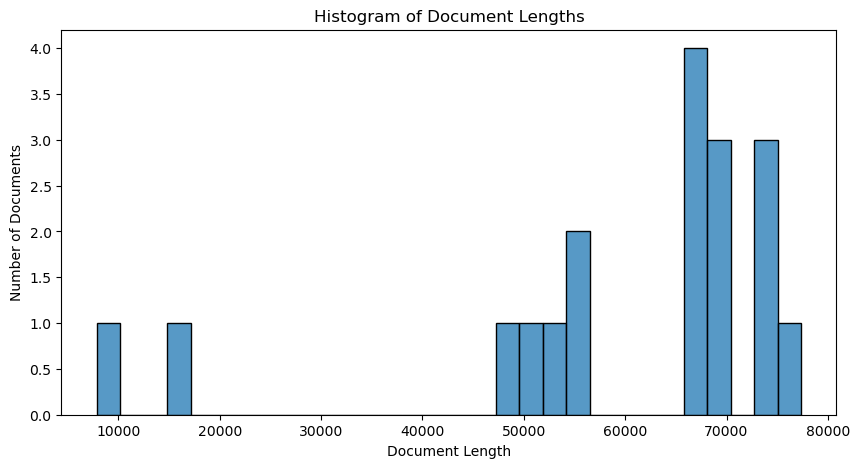

In [23]:
def plot_doc_lengths(corpus):
    doc_lengths = get_doc_lengths(corpus)

    plt.figure(figsize=(10, 5))
    sns.histplot(doc_lengths, kde=False, bins=30)
    plt.xlabel("Document Length")
    plt.ylabel("Number of Documents")
    plt.title("Histogram of Document Lengths")
    plt.show()
plot_doc_lengths(corpus)


In [24]:
import re
from nltk.tokenize import RegexpTokenizer

def extract_metadata(text):
    metadata = {}
    # Extract metadata here (e.g., title, author, date, etc.)
    # Example: metadata['title'] = re.search('TITLE_PATTERN', text).group(1)
    
    # Remove metadata from the text
    cleaned_text = re.sub('METADATA_PATTERN', '', text)
    return metadata, cleaned_text

def preprocess_data(raw_data):
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')  # Tokenizes words and punctuation marks

    preprocessed_data = []
    metadata_list = []

    for document in raw_data:
        metadata, cleaned_text = extract_metadata(document)
        metadata_list.append(metadata)

        tokenized_words = tokenizer.tokenize(cleaned_text.lower())
        cleaned_words = [word for word in tokenized_words if word.isalnum() and word not in stop_words]
        lemmatized_words = [lemmatizer.lemmatize(word) for word in cleaned_words]
        preprocessed_data.append(lemmatized_words)
    
    return metadata_list, preprocessed_data

metadata_list, preprocessed_data = preprocess_data(corp)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saijagadeeshyadavalli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saijagadeeshyadavalli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saijagadeeshyadavalli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Topic modeling

**Building LDA Model**

In [25]:
from gensim.models import LdaModel

def train_lda(corpus, dictionary, num_topics=5, passes=10, random_state=42):
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=random_state)
    return lda_model

In [26]:
num_topics = 10
lda_model1 = train_lda(corpus, dictionary, num_topics=num_topics)

In [27]:
def print_topics(lda_model, num_words=10):
    topics = lda_model.print_topics(num_words=num_words)
    for topic_no, topic_words in topics:
        print(f"Topic {topic_no}: {topic_words}")

print_topics(lda_model1, num_words=10)

Topic 0: 0.010*"said" + 0.008*"state" + 0.007*"new" + 0.007*"time" + 0.005*"york" + 0.004*"islamic" + 0.004*"one" + 0.004*"would" + 0.004*"trump" + 0.004*"people"
Topic 1: 0.011*"said" + 0.009*"state" + 0.006*"islamic" + 0.006*"new" + 0.005*"time" + 0.005*"trump" + 0.004*"force" + 0.004*"year" + 0.004*"one" + 0.004*"right"
Topic 2: 0.004*"state" + 0.004*"said" + 0.002*"trump" + 0.002*"islamic" + 0.002*"american" + 0.002*"new" + 0.002*"one" + 0.001*"force" + 0.001*"would" + 0.001*"time"
Topic 3: 0.012*"trump" + 0.011*"said" + 0.011*"state" + 0.006*"islamic" + 0.006*"syria" + 0.006*"president" + 0.005*"new" + 0.004*"time" + 0.004*"american" + 0.004*"military"
Topic 4: 0.008*"said" + 0.007*"attack" + 0.007*"trump" + 0.006*"state" + 0.004*"police" + 0.004*"year" + 0.004*"president" + 0.004*"think" + 0.004*"islamic" + 0.004*"syria"
Topic 5: 0.011*"said" + 0.010*"state" + 0.007*"trump" + 0.007*"time" + 0.006*"new" + 0.006*"islamic" + 0.004*"one" + 0.004*"american" + 0.004*"york" + 0.004*"peo

In [28]:
def save_topics_to_file(lda_model, filename, num_words=10):
    topics = lda_model1.print_topics(num_words=num_words)
    with open(filename, 'w') as file:
        for topic_no, topic_words in topics:
            file.write(f"Topic {topic_no}: {topic_words}\n")
            
#save_topics_to_file(lda_model1, filename, num_words=10)

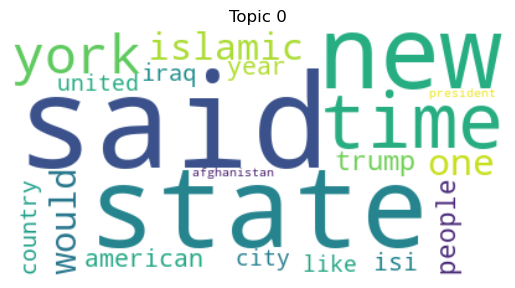

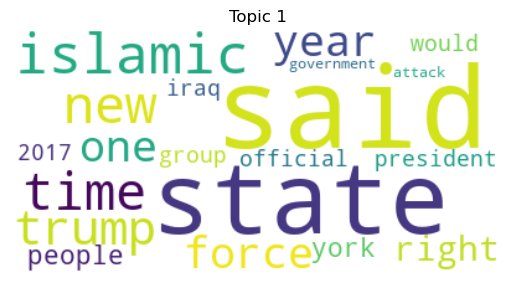

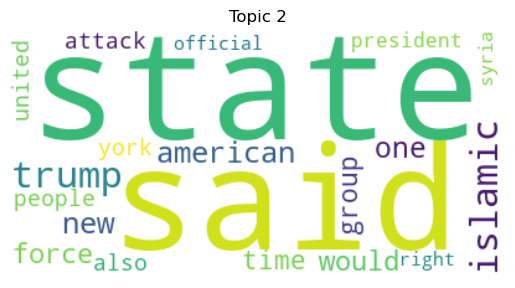

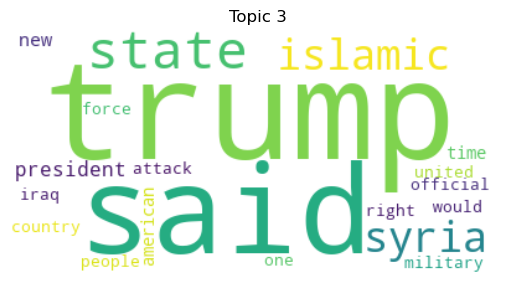

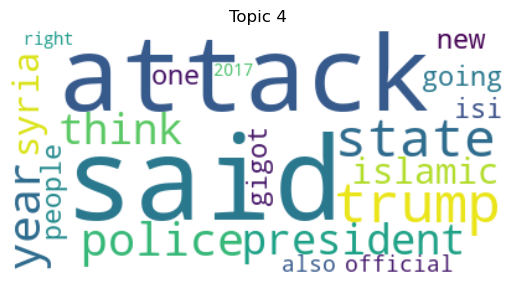

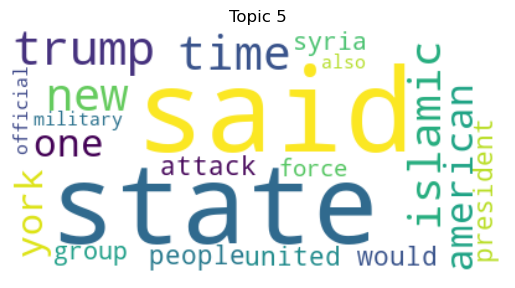

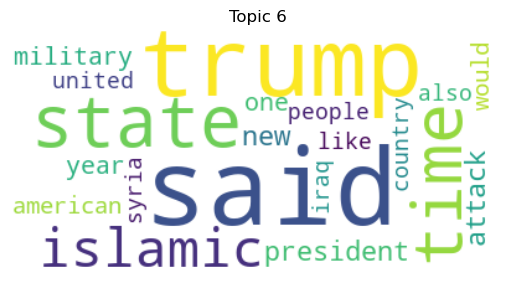

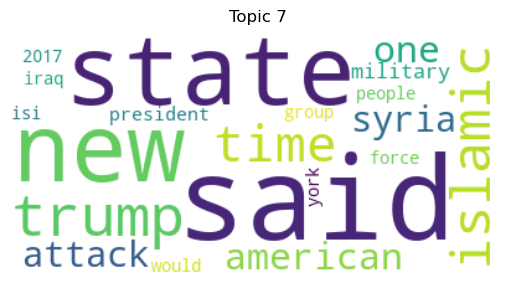

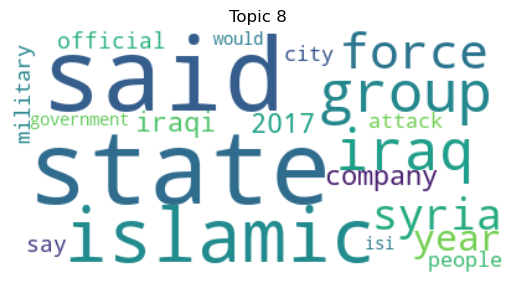

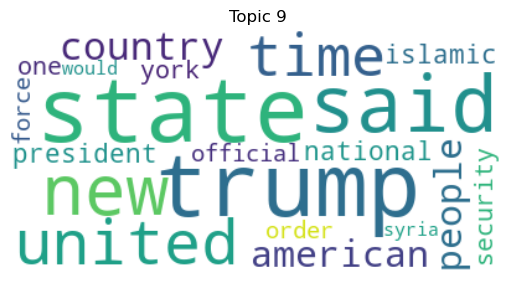

In [29]:
# Generate wordclouds for each topic
for topic_num in range(lda_model1.num_topics):
    words = dict(lda_model1.show_topic(topic_num, topn=20))
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Topic {}".format(topic_num))
    plt.show()

Topic 0 seems to be related to a specific event that happened in Manchester and mentions the name "Abedi" along with other related words like "arena" and "Grande". This could be referring to the 2017 Manchester Arena bombing.

Topic 1 appears to be a general topic that mentions words like "president," "American," and "right." It is unclear what specific event or topic this could be referring to.

Topic 2 seems to be focused on the state of New York and mentions the word "ISI," which is likely a reference to ISIS. It is possible that this topic is discussing the presence or activity of ISIS in New York.

Topic 3 also mentions ISIS and appears to be focused on their activity in Syria. The topic also includes words like "attack" and "president," which could be referring to a specific incident or action taken by the president in response to ISIS activity.

Topic 4 appears to be a continuation of the previous topic, discussing ISIS and their presence in Syria.

Topic 5 is focused on the United States and mentions the current president, Donald Trump, along with words like "American" and "country." This could be referring to various political or social issues within the United States.

Topic 6 mentions hacking and a team, and it is possible that this topic is related to cyber attacks or cybersecurity in general.

Topic 7 appears to be a continuation of the previous topic, discussing news related to the state of New York and the United States in general.

Topic 8 seems to be focused on a specific attack and mentions words like "police," "year," and "think." It is unclear what specific event this topic could be referring to.

Topic 9 mentions the president and the military force, possibly discussing a specific military action taken by the president in response to a threat posed by ISIS.

Overall, the topics appear to be a mix of specific events and general news topics, with a focus on ISIS and the United States. 

**Re-run the topic modeling multiple times with different parameters and store summaries into output files**

In [30]:
num_topics_values = [3, 5, 7,10]
num_passes_values = [5, 10, 20]

for num_topics in num_topics_values:
    for passes in num_passes_values:
        print(f"Training LDA model with {num_topics} topics and {passes} passes.")
        lda_model = train_lda(corpus, dictionary, num_topics=num_topics, passes=passes)
        
        print(f"Topics for LDA model with {num_topics} topics and {passes} passes:")
        print_topics(lda_model, num_words=10)
        
        output_filename = f"lda_topics_{num_topics}_topics_{passes}_passes.txt"
        save_topics_to_file(lda_model, output_filename, num_words=10)
        print(f"Saved topics to {output_filename}\n")

Training LDA model with 3 topics and 5 passes.
Topics for LDA model with 3 topics and 5 passes:
Topic 0: 0.010*"said" + 0.008*"state" + 0.008*"new" + 0.008*"time" + 0.005*"york" + 0.005*"islamic" + 0.004*"trump" + 0.004*"one" + 0.004*"american" + 0.004*"would"
Topic 1: 0.012*"said" + 0.010*"state" + 0.007*"trump" + 0.007*"islamic" + 0.005*"syria" + 0.004*"new" + 0.004*"force" + 0.004*"time" + 0.004*"president" + 0.004*"official"
Topic 2: 0.010*"state" + 0.010*"trump" + 0.010*"said" + 0.006*"new" + 0.005*"islamic" + 0.005*"time" + 0.005*"united" + 0.005*"president" + 0.004*"american" + 0.004*"one"
Saved topics to lda_topics_3_topics_5_passes.txt

Training LDA model with 3 topics and 10 passes.
Topics for LDA model with 3 topics and 10 passes:
Topic 0: 0.010*"said" + 0.008*"state" + 0.008*"new" + 0.008*"time" + 0.005*"york" + 0.005*"islamic" + 0.004*"trump" + 0.004*"one" + 0.004*"american" + 0.004*"people"
Topic 1: 0.011*"said" + 0.010*"state" + 0.007*"trump" + 0.007*"islamic" + 0.005*"s

Topics for LDA model with 10 topics and 5 passes:
Topic 0: 0.010*"said" + 0.008*"new" + 0.008*"state" + 0.007*"time" + 0.005*"york" + 0.004*"islamic" + 0.004*"one" + 0.004*"would" + 0.004*"trump" + 0.004*"people"
Topic 1: 0.012*"said" + 0.009*"state" + 0.006*"islamic" + 0.006*"new" + 0.005*"time" + 0.005*"trump" + 0.004*"force" + 0.004*"york" + 0.004*"official" + 0.004*"one"
Topic 2: 0.009*"state" + 0.009*"said" + 0.005*"trump" + 0.005*"islamic" + 0.004*"american" + 0.004*"new" + 0.004*"one" + 0.004*"force" + 0.003*"would" + 0.003*"time"
Topic 3: 0.012*"trump" + 0.011*"said" + 0.010*"state" + 0.006*"islamic" + 0.006*"syria" + 0.005*"new" + 0.005*"president" + 0.005*"time" + 0.004*"american" + 0.004*"military"
Topic 4: 0.009*"said" + 0.008*"state" + 0.007*"trump" + 0.006*"attack" + 0.005*"president" + 0.004*"new" + 0.004*"year" + 0.004*"islamic" + 0.004*"syria" + 0.004*"people"
Topic 5: 0.011*"said" + 0.010*"state" + 0.007*"trump" + 0.006*"time" + 0.006*"islamic" + 0.006*"new" + 0.005*"

In [31]:
import pyLDAvis.gensim_models

vis_data = pyLDAvis.gensim_models.prepare(lda_model1, corpus, dictionary)
#pyLDAvis.display(vis_data)

#visualize_lda_model(lda_model, corpus, dictionary)
# Save visualization to file
pyLDAvis.save_html(vis_data, 'lda_vis.html')


In [32]:
pyLDAvis.display(vis_data)

In [33]:
def get_topic_top_words(lda_model, topic_id, num_words=10):
    words_and_probs = lda_model.show_topic(topic_id, topn=num_words)
    return words_and_probs

topic_top_words = {}
for topic_id in range(num_topics):
    topic_top_words[topic_id] = get_topic_top_words(lda_model, topic_id)

for topic_id, top_words in topic_top_words.items():
    print(f"Topic {topic_id}:")
    for word, probability in top_words:
        print(f"    {word}: {probability:.4f}")

Topic 0:
    said: 0.0103
    state: 0.0076
    new: 0.0075
    time: 0.0068
    york: 0.0047
    islamic: 0.0045
    one: 0.0045
    would: 0.0040
    trump: 0.0039
    people: 0.0038
Topic 1:
    said: 0.0112
    state: 0.0088
    islamic: 0.0064
    new: 0.0054
    time: 0.0054
    trump: 0.0047
    year: 0.0037
    one: 0.0037
    force: 0.0037
    right: 0.0037
Topic 2:
    state: 0.0003
    said: 0.0003
    trump: 0.0002
    islamic: 0.0002
    american: 0.0002
    new: 0.0002
    one: 0.0002
    force: 0.0001
    would: 0.0001
    time: 0.0001
Topic 3:
    trump: 0.0116
    said: 0.0111
    state: 0.0107
    syria: 0.0061
    islamic: 0.0060
    president: 0.0058
    new: 0.0050
    time: 0.0044
    american: 0.0043
    military: 0.0040
Topic 4:
    said: 0.0079
    attack: 0.0075
    trump: 0.0066
    state: 0.0056
    police: 0.0047
    think: 0.0045
    year: 0.0044
    president: 0.0041
    going: 0.0038
    islamic: 0.0038
Topic 5:
    said: 0.0113
    state: 0.0101
    tru

**Result Discusssion**

Topic 0 seems to be related to a specific event that happened in Manchester and mentions the name "Abedi" along with other related words like "arena" and "Grande". This could be referring to the 2017 Manchester Arena bombing.

Topic 1 appears to be a general topic that mentions words like "president," "American," and "right." It is unclear what specific event or topic this could be referring to.

Topic 2 seems to be focused on the state of New York and mentions the word "ISI," which is likely a reference to ISIS. It is possible that this topic is discussing the presence or activity of ISIS in New York.

Topic 3 also mentions ISIS and appears to be focused on their activity in Syria. The topic also includes words like "attack" and "president," which could be referring to a specific incident or action taken by the president in response to ISIS activity.

Topic 4 appears to be a continuation of the previous topic, discussing ISIS and their presence in Syria.

Topic 5 is focused on the United States and mentions the current president, Donald Trump, along with words like "American" and "country." This could be referring to various political or social issues within the United States.

Topic 6 mentions hacking and a team, and it is possible that this topic is related to cyber attacks or cybersecurity in general.

Overall, the topics appear to be a mix of specific events and general news topics, with a focus on ISIS and the United States. 

**Outputs and visualizations**

In [34]:
def get_document_topic_proportions(lda_model, corpus):
    topic_proportions = []
    for doc_topics in lda_model.get_document_topics(corpus):
        proportions = {topic_id: 0 for topic_id in range(lda_model.num_topics)}
        for topic_id, proportion in doc_topics:
            proportions[topic_id] = proportion
        topic_proportions.append(proportions)
    return topic_proportions

document_topic_proportions = get_document_topic_proportions(lda_model, corpus)
document_topic_proportions

[{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0.9955327},
 {0: 0,
  1: 0,
  2: 0,
  3: 0.9652792,
  4: 0,
  5: 0.029155113,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0.9964748, 6: 0, 7: 0, 8: 0, 9: 0},
 {0: 0,
  1: 0.03224481,
  2: 0,
  3: 0.024669828,
  4: 0,
  5: 0.94068575,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0.9861133, 6: 0, 7: 0, 8: 0, 9: 0},
 {0: 0, 1: 0, 2: 0, 3: 0.99113035, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
 {0: 0.92762446,
  1: 0,
  2: 0,
  3: 0.012622216,
  4: 0,
  5: 0.05841617,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 {0: 0,
  1: 0.016406424,
  2: 0,
  3: 0,
  4: 0,
  5: 0.97069454,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 {0: 0.9934332, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
 {0: 0.9646909,
  1: 0.012931032,
  2: 0,
  3: 0,
  4: 0,
  5: 0.0123191355,
  6: 0,
  7: 0,
  8: 0,
  9: 0},
 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0.9939592, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
 {0: 0.021270301,
  1: 0.9553907,
  2: 0,
  3:

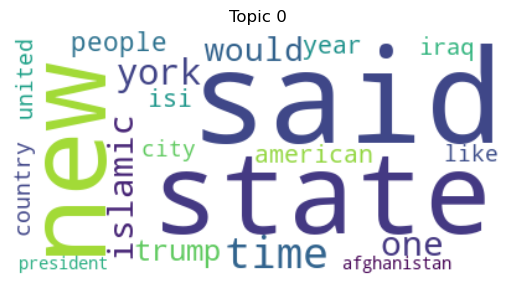

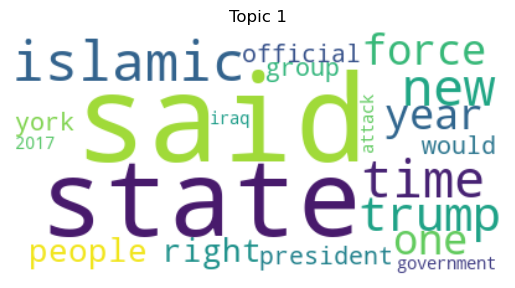

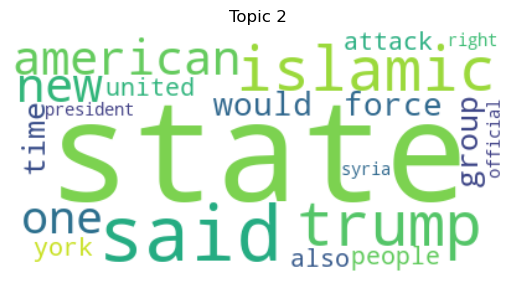

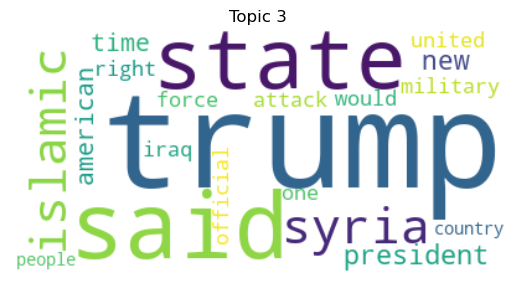

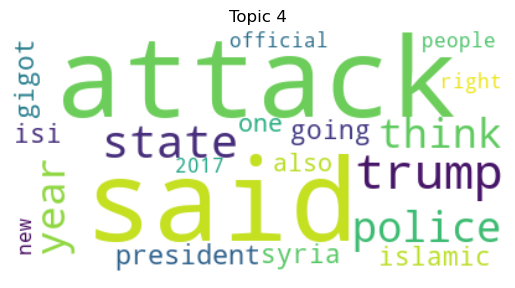

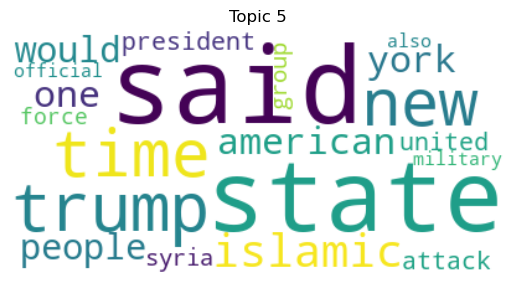

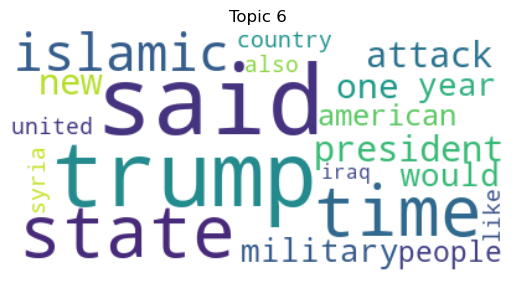

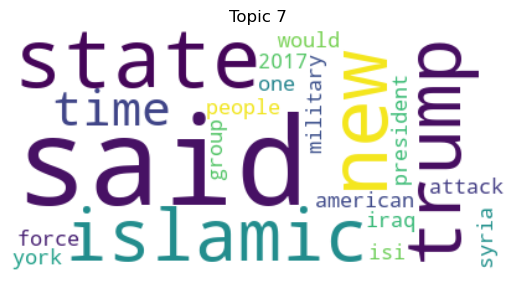

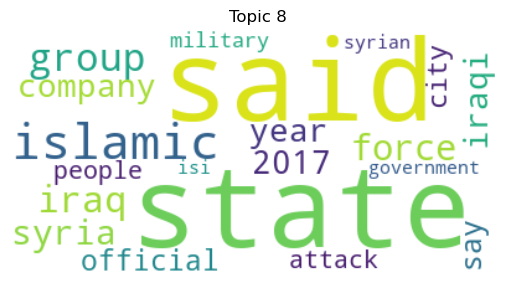

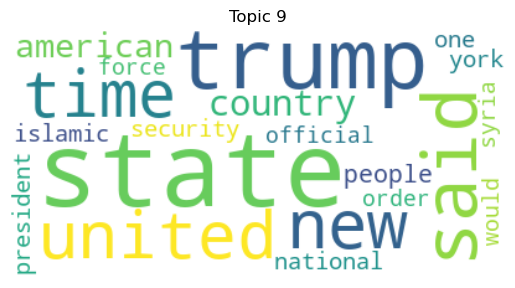

In [35]:
# Generate wordclouds for each topic
for topic_num in range(lda_model.num_topics):
    words = dict(lda_model.show_topic(topic_num, topn=20))
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Topic {}".format(topic_num))
    plt.show()